**Sources:**

The code is a further development of this preliminary project:

[1] https://github.com/bjorneme/preliminary/tree/main

The state-of-the-art model used as inspiration for multi-label classification on ChestX-ray14 is:

[2] https://github.com/syednabilashraf/SynthEnsemble/tree/main

The code used for develop BYOL architecture is:

[3] https://docs.lightly.ai/self-supervised-learning/examples/byol.html

The code used for TTA is:

[4] https://github.com/taheeraahmed/master-thesis

**Import Libraries**

In [17]:
pip install lightly mambavision transformers mamba_ssm timm

Note: you may need to restart the kernel to use updated packages.


In [18]:
# Standard Libraries
import os
import copy
import random
from glob import glob
from PIL import Image
import zipfile

# Data Manipulation Libraries
import pandas as pd
import numpy as np

# Visualization Libraries
import matplotlib.pyplot as plt

# Progress Bar
from tqdm import tqdm

# Machine Learning Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, f1_score
from torch.amp import GradScaler, autocast

# BYOL library
from lightly.transforms.byol_transform import BYOLTransform, BYOLView1Transform, BYOLView2Transform
from lightly.models.modules import BYOLProjectionHead, BYOLPredictionHead
from lightly.models.utils import deactivate_requires_grad, update_momentum
from lightly.loss import NegativeCosineSimilarity
from lightly.utils.scheduler import cosine_schedule

# Hugging Face transformers to load the MambaVision model
from transformers import AutoModel

**Define Parameters**

In [19]:
# Paths
ZIP_PATH = '/cluster/home/bjorneme/projects/Data/chestX-ray14.zip'
EXTRACTED_PATH = '/cluster/home/bjorneme/projects/Data/chestX-ray14-extracted'

# Model
MODEL_NAME = "nvidia/MambaVision-T2-1K"

# Disease labels
disease_labels = [
    'Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema',
    'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening',
    'Cardiomegaly', 'Nodule', 'Mass', 'Hernia'
]

# Parameters BYOL pre-training
LEARNING_RATE_BYOL = 0.001
EPOCHS_BYOL = 500
BATCH_SIZE_BYOL = 256

# Parameter learning rate scheduler BYOL
STEP_SIZE = 25
GAMMA = 0.5

# Parameters training
LEARNING_RATE = 0.001
LEARNING_RATE_FINE_TUNING = 0.0001
EPOCHS = 3
EPOCHS_FINE_TUNING = 100
BATCH_SIZE = 32

# Parameters early stopping
EARLY_STOPPING_PATIENCE_BYOL = 25
EARLY_STOPPING_PATIENCE = 10

# Parameters learning rate scheduler
LEARNING_RATE_SCHEDULER_PATIENCE = 1
LEARNING_RATE_SCHEDULER_MODE = 'min'
LEARNING_RATE_SCHEDULER_FACTOR = 0.1

# Other parameters
SEED = 42
NUM_WORKERS = 32

# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


**Set Seed for Reproducibility**

In [20]:
def seed_everything(seed=SEED):
    """
    Sets the seed to ensure reproducibility.
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Apply the seed
seed_everything()

# **Step 1: Load Data**

In [ ]:
def extract_data(zip_path, extracted_path):
    """
    Extracts the ZIP file of the dataset.
    """
    os.makedirs(extracted_path, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_path)

# Extract ChestX-ray14 dataset
# TODO: Uncomment to extract data from zip
# extract_data(ZIP_PATH, EXTRACTED_PATH)

# **Step 2: Data Preprocessing**

In [22]:
def load_labels(csv_path, extracted_path):
    """
    Read labels from CSV, maps images to paths, and create binary disease labels.
    """

    # Read the CSV containing labels
    labels_df = pd.read_csv(csv_path)

    # Create binary columns for each disease label
    for disease in disease_labels:
        labels_df[disease] = labels_df['Finding Labels'].str.contains(disease).astype(int)

    # Create binary column for 'No Finding'
    labels_df['No Finding'] = labels_df['Finding Labels'].str.contains('No Finding').astype(int)

    # Map images to their full path
    labels_df['Path'] = labels_df['Image Index'].map(
        {os.path.basename(path): path for path in glob(os.path.join(extracted_path, '**', 'images', '*.png'))}
    )
    
    return labels_df

# Path to the labels CSV file
labels_csv_path = os.path.join(EXTRACTED_PATH, 'Data_Entry_2017.csv')

# Load and preprocess the labels
df = load_labels(labels_csv_path, EXTRACTED_PATH)

**Split Dataset**

In [23]:
# Split based on patients
unique_patients = df['Patient ID'].unique()

# Split patients into training, validation and test sets
train_val_patients, test_patients = train_test_split(
    unique_patients, test_size=0.2, random_state=SEED
)
train_patients, val_patients = train_test_split(
    train_val_patients, test_size=0.125, random_state=SEED
)

# Create dataframes for training, validation, and test sets
train_df = df[df['Patient ID'].isin(train_patients)].reset_index(drop=True)
val_df = df[df['Patient ID'].isin(val_patients)].reset_index(drop=True)
test_df = df[df['Patient ID'].isin(test_patients)].reset_index(drop=True)

# Verify Split Sizes
print(f"Train dataset size: {len(train_df)}. Number of unique patients: {len(train_patients)}")
print(f"Validation size: {len(val_df)}. Number of unique patients: {len(val_patients)}")
print(f"Test size: {len(test_df)}. Number of unique patients: {len(test_patients)}")

Train dataset size: 78614. Number of unique patients: 21563
Validation size: 11212. Number of unique patients: 3081
Test size: 22294. Number of unique patients: 6161


**Define Dataset for Chest X-ray images**

In [24]:
class ChestXrayDataset(Dataset):
    """
    Create dataset for Chest X-ray images.
    """
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        
        # Get image and labels
        img_path = self.df.iloc[idx]['Path']
        image = plt.imread(img_path)
        label = self.df.iloc[idx][disease_labels].values.astype(np.float32)
        
        # Apply transformation on image
        image = self.transform(image)
        
        return image, label

**Define Data Transformations**

In [25]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

# Define transformations for training data
train_transforms = transforms.Compose([

    # Convert image to PIL format
    transforms.ToPILImage(),

    # Convert to 3 channels
    transforms.Grayscale(num_output_channels=3),

    # Resize the image to 256x256
    transforms.Resize((256,256)),

    # Randomly 224x224 crops
    transforms.RandomCrop(224),

    # Apply random horizontal flip
    transforms.RandomHorizontalFlip(),

    # Randomly rotate the image with ±10 degrees
    transforms.RandomRotation(10),

    # Convert the image to a PyTorch tensor
    transforms.ToTensor(),

    # Normalize using ImageNet mean and std
    transforms.Normalize(mean=mean, std=std)
])

# Define transformations for test data
test_transforms = transforms.Compose([

    # Convert image to PIL format
    transforms.ToPILImage(),

    # Convert to 3 channels
    transforms.Grayscale(num_output_channels=3),

    # Resize the image to 256x256
    transforms.Resize((256,256)),

    # Create 10 crops
    transforms.TenCrop(224),
    transforms.Lambda(lambda crops: torch.stack([
        transforms.ToTensor()(crop) for crop in crops
    ])),

    # Normalize using ImageNet mean and std
    transforms.Lambda(lambda crops: torch.stack(
        [transforms.Normalize(mean, std)(crop) for crop in crops]
    ))
])

**Create Datasets**

In [26]:
train_dataset = ChestXrayDataset(train_df, transform=train_transforms)
val_dataset = ChestXrayDataset(val_df, transform=test_transforms)
test_dataset = ChestXrayDataset(test_df, transform=test_transforms)

**Create DataLoaders**

In [27]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

# **Step 3: BYOL Pre-training**

**Define the BYOL transformations**

In [28]:
byol_transform = transforms.Compose([
        
    # Convert image to PIL format
    transforms.ToPILImage(),

    # Convert to 3 channels
    transforms.Grayscale(num_output_channels=3),

    # Resize the image to 256x256
    transforms.Resize((256,256)),

    # Randomly 224x224 crops
    transforms.RandomCrop(224),

    # Apply random horizontal flip
    transforms.RandomHorizontalFlip(),

    # Randomly rotate the image with ±10 degrees
    transforms.RandomRotation(10),

    # Apply random brightness
    transforms.ColorJitter(
        brightness=(0.8, 1.2),
    ),

    # Apply random contrast
    transforms.ColorJitter(
        contrast=(0.8, 1.2),
    ),

    # Convert the image to a PyTorch tensor
    transforms.ToTensor(),

    # Normalize using ImageNet mean and std
    transforms.Normalize(mean=mean, std=std),

    # Apply random erasing of image
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.1)),

    # Apply random erasing of image
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.1)),

    # Apply random erasing of image
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.1))
])

**Define the BYOL model**

In [29]:
class BYOL(nn.Module):
    def __init__(self, model_name="nvidia/MambaVision-T2-1K"):
        super().__init__()

        # The online network
        self.online_network = AutoModel.from_pretrained(model_name, trust_remote_code=True)
        self.online_network_projection_head = BYOLProjectionHead(self.online_network.model.head.in_features, 1024, 256)
        self.online_network_prediction_head = BYOLPredictionHead(256, 1024, 256)

        # The target network
        self.target_network = copy.deepcopy(self.online_network)
        self.target_network_projection_head = copy.deepcopy(self.online_network_projection_head)

        # Freeze the target network. Only update using EMA
        deactivate_requires_grad(self.target_network)
        deactivate_requires_grad(self.target_network_projection_head)

    def forward_online_network(self, x):
        # Forward pass online network
        y, _ = self.online_network(x)
        z = self.online_network_projection_head(y)
        return self.online_network_prediction_head(z)

    def forward_target_network(self, x):
        # Forward pass target network
        y, _ = self.target_network(x)
        z = self.target_network_projection_head(y)
        return z.detach()

# Initalize BYOL model
byol_model = BYOL(MODEL_NAME).to(device)

**Create BYOL Dataset**

In [30]:
class BYOLDataset(torch.utils.data.Dataset):
    """
    Dataset for BYOL.
    Returns two augmented versions of each image.
    """
    def __init__(self, df, transform):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Get image path
        img_path = self.df.iloc[idx]['Path']
        image = plt.imread(img_path)

        # Apply the BYOL transform on image
        view1 = self.transform(image)
        view2 = self.transform(image)

        # Return two different views
        return view1, view2

# Create dataset for training and validation using BYOL
byol_train_dataset = BYOLDataset(train_df, transform=byol_transform)
byol_val_dataset = BYOLDataset(val_df, transform=byol_transform)

**Initialize BYOL DataLoader**

In [31]:
# Initialize loader for BYOL training
byol_train_loader = DataLoader(
    byol_train_dataset,
    batch_size=BATCH_SIZE_BYOL,
    shuffle=True,
    num_workers=NUM_WORKERS,
    drop_last=True
)

# Initialize loader for BYOL validation
byol_val_loader = DataLoader(
    byol_val_dataset,
    batch_size=BATCH_SIZE_BYOL,
    shuffle=False,
    num_workers=NUM_WORKERS,
    drop_last=False
)

**Initialize Optimizer, Scheduler and Loss for BYOL**

In [32]:
criterion = NegativeCosineSimilarity()
optimizer_byol = torch.optim.AdamW(byol_model.parameters(), lr=LEARNING_RATE_BYOL)
scheduler_byol = torch.optim.lr_scheduler.StepLR(
    optimizer_byol, step_size=STEP_SIZE, gamma=GAMMA
)


**Train BYOL Model**

In [33]:
def train_model(byol_model, byol_train_loader, byol_val_loader, criterion, optimizer, scheduler, patience, epochs=10):
    """
    Pre-train the backbone and evaluate it on the validation set after each epoch.
    """

    # List to store byol loss
    byol_train_losses = []
    byol_val_losses = []

    # Early stopping parameters
    best_loss = 0
    epochs_without_improvement = 0

    for epoch in range(epochs):

        # ---Training---
        byol_model.train()
        train_loss = 0.0

        # For mixed precision
        scaler = GradScaler()

        # Progress bar
        progress_bar = tqdm(byol_train_loader, desc=f"BYOL Epoch {epoch+1}/{epochs}")

        momentum_val = cosine_schedule(epoch, epochs, 0.996, 1)

        for batch in progress_bar:
            x0, x1 = batch
            update_momentum(byol_model.online_network, byol_model.target_network, m=momentum_val)
            update_momentum(byol_model.online_network_projection_head, byol_model.target_network_projection_head, m=momentum_val)

            x0 = x0.to(device)
            x1 = x1.to(device)

            # Clear gradients
            optimizer.zero_grad()

            with autocast('cuda'):

                # Forward pass
                p0 = byol_model.forward_online_network(x0)
                z0 = byol_model.forward_target_network(x0)
                p1 = byol_model.forward_online_network(x1)
                z1 = byol_model.forward_target_network(x1)

                # Compute loss
                loss = 0.5 * (criterion(p0, z1) + criterion(p1, z0))

            # Backward pass + scaling
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item()
            progress_bar.set_postfix({"Loss": loss.item()})

        # Calculate average training loss
        train_loss = train_loss / len(byol_train_loader)
        byol_train_losses.append(train_loss)


        # ---Validation---
        byol_model.eval()
        val_loss = 0

        # Progress bar
        progress_bar = tqdm(byol_val_loader, desc=f"BYOL Epoch {epoch+1}/{epochs}")

        # Disable gradients for evaluation
        with torch.no_grad():
            for batch in progress_bar:
                x0, x1 = batch

                x0 = x0.to(device)
                x1 = x1.to(device)

                # Forward pass
                p0 = byol_model.forward_online_network(x0)
                z0 = byol_model.forward_target_network(x0)
                p1 = byol_model.forward_online_network(x1)
                z1 = byol_model.forward_target_network(x1)

                # Compute loss
                loss = 0.5 * (criterion(p0, z1) + criterion(p1, z0))

                val_loss  += loss.item()
                progress_bar.set_postfix({"Loss": loss.item()})

        # Calculate average validation loss
        val_loss = val_loss / len(byol_val_loader)
        byol_val_losses.append(val_loss)

        # Update scheduler
        scheduler.step()

        print(f"Epoch {epoch+1}/{epochs} | Training Loss: {train_loss:.4f} | "
              f"Validation Loss: {val_loss:.4f}")

        # Early stopping
        if best_loss > val_loss:

            # Reset early stopping parameters
            best_loss = val_loss
            epochs_without_improvement = 0

            # Save the best model
            torch.save(byol_model.state_dict(), 'byol_Step_Decay_augmentation.pt')
            print(f"New best model with Validation Loss: {val_loss:.4f}")
        else:
            epochs_without_improvement += 1

            # Condition for doing early stopping
            if epochs_without_improvement >= patience :
                print(f"Early stopping.")
                break

    # Load the best model
    byol_model.load_state_dict(torch.load('byol_Step_Decay_augmentation.pt', weights_only=True))

    return byol_train_losses, byol_val_losses

# Train the model
byol_train_losses, byol_val_losses = train_model(byol_model, byol_train_loader, byol_val_loader, criterion, optimizer_byol, scheduler_byol, EARLY_STOPPING_PATIENCE_BYOL, EPOCHS_BYOL)

BYOL Epoch 1/500:   0%|          | 0/307 [00:00<?, ?it/s]

BYOL Epoch 1/500: 100%|██████████| 44/44 [00:27<00:00,  1.61it/s, Loss=-0.965]


Epoch 1/500 | Training Loss: -0.8428 | Validation Loss: -0.9613
New best model with Validation Loss: -0.9613


BYOL Epoch 2/500: 100%|██████████| 44/44 [00:26<00:00,  1.69it/s, Loss=-0.985]


Epoch 2/500 | Training Loss: -0.9714 | Validation Loss: -0.9801
New best model with Validation Loss: -0.9801


BYOL Epoch 3/500: 100%|██████████| 44/44 [00:26<00:00,  1.68it/s, Loss=-0.987]


Epoch 3/500 | Training Loss: -0.9825 | Validation Loss: -0.9846
New best model with Validation Loss: -0.9846


BYOL Epoch 4/500: 100%|██████████| 44/44 [00:26<00:00,  1.68it/s, Loss=-0.989]


Epoch 4/500 | Training Loss: -0.9851 | Validation Loss: -0.9851
New best model with Validation Loss: -0.9851


BYOL Epoch 5/500: 100%|██████████| 44/44 [00:26<00:00,  1.69it/s, Loss=-0.989]


Epoch 5/500 | Training Loss: -0.9861 | Validation Loss: -0.9853
New best model with Validation Loss: -0.9853


BYOL Epoch 6/500: 100%|██████████| 44/44 [00:26<00:00,  1.68it/s, Loss=-0.989]


Epoch 6/500 | Training Loss: -0.9866 | Validation Loss: -0.9871
New best model with Validation Loss: -0.9871


BYOL Epoch 7/500: 100%|██████████| 44/44 [00:26<00:00,  1.68it/s, Loss=-0.99] 


Epoch 7/500 | Training Loss: -0.9868 | Validation Loss: -0.9872
New best model with Validation Loss: -0.9872


BYOL Epoch 8/500: 100%|██████████| 44/44 [00:26<00:00,  1.68it/s, Loss=-0.987]


Epoch 8/500 | Training Loss: -0.9872 | Validation Loss: -0.9831


BYOL Epoch 9/500: 100%|██████████| 44/44 [00:26<00:00,  1.68it/s, Loss=-0.989]


Epoch 9/500 | Training Loss: -0.9873 | Validation Loss: -0.9859


BYOL Epoch 10/500: 100%|██████████| 44/44 [00:26<00:00,  1.68it/s, Loss=-0.99] 


Epoch 10/500 | Training Loss: -0.9874 | Validation Loss: -0.9864


BYOL Epoch 11/500: 100%|██████████| 44/44 [00:26<00:00,  1.68it/s, Loss=-0.989]


Epoch 11/500 | Training Loss: -0.9876 | Validation Loss: -0.9870


BYOL Epoch 12/500: 100%|██████████| 44/44 [00:26<00:00,  1.68it/s, Loss=-0.99] 


Epoch 12/500 | Training Loss: -0.9876 | Validation Loss: -0.9873
New best model with Validation Loss: -0.9873


BYOL Epoch 13/500: 100%|██████████| 44/44 [00:26<00:00,  1.68it/s, Loss=-0.99] 


Epoch 13/500 | Training Loss: -0.9876 | Validation Loss: -0.9879
New best model with Validation Loss: -0.9879


BYOL Epoch 14/500: 100%|██████████| 44/44 [00:26<00:00,  1.68it/s, Loss=-0.99] 


Epoch 14/500 | Training Loss: -0.9877 | Validation Loss: -0.9869


BYOL Epoch 15/500: 100%|██████████| 44/44 [00:26<00:00,  1.67it/s, Loss=-0.99] 


Epoch 15/500 | Training Loss: -0.9877 | Validation Loss: -0.9875


BYOL Epoch 16/500: 100%|██████████| 44/44 [00:26<00:00,  1.67it/s, Loss=-0.99] 


Epoch 16/500 | Training Loss: -0.9880 | Validation Loss: -0.9876


BYOL Epoch 17/500: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s, Loss=-0.989]


Epoch 17/500 | Training Loss: -0.9879 | Validation Loss: -0.9864


BYOL Epoch 18/500: 100%|██████████| 44/44 [00:26<00:00,  1.67it/s, Loss=-0.99] 


Epoch 18/500 | Training Loss: -0.9879 | Validation Loss: -0.9878


BYOL Epoch 19/500: 100%|██████████| 44/44 [00:26<00:00,  1.68it/s, Loss=-0.99] 


Epoch 19/500 | Training Loss: -0.9880 | Validation Loss: -0.9875


BYOL Epoch 20/500: 100%|██████████| 44/44 [00:26<00:00,  1.67it/s, Loss=-0.991]


Epoch 20/500 | Training Loss: -0.9881 | Validation Loss: -0.9883
New best model with Validation Loss: -0.9883


BYOL Epoch 21/500: 100%|██████████| 44/44 [00:26<00:00,  1.68it/s, Loss=-0.989]


Epoch 21/500 | Training Loss: -0.9881 | Validation Loss: -0.9872


BYOL Epoch 22/500: 100%|██████████| 44/44 [00:26<00:00,  1.68it/s, Loss=-0.991]


Epoch 22/500 | Training Loss: -0.9882 | Validation Loss: -0.9886
New best model with Validation Loss: -0.9886


BYOL Epoch 23/500: 100%|██████████| 44/44 [00:26<00:00,  1.67it/s, Loss=-0.99] 


Epoch 23/500 | Training Loss: -0.9883 | Validation Loss: -0.9884


BYOL Epoch 24/500: 100%|██████████| 44/44 [00:26<00:00,  1.67it/s, Loss=-0.99] 


Epoch 24/500 | Training Loss: -0.9885 | Validation Loss: -0.9860


BYOL Epoch 25/500: 100%|██████████| 44/44 [00:27<00:00,  1.61it/s, Loss=-0.992]


Epoch 25/500 | Training Loss: -0.9886 | Validation Loss: -0.9880


BYOL Epoch 26/500: 100%|██████████| 44/44 [00:26<00:00,  1.67it/s, Loss=-0.992]


Epoch 26/500 | Training Loss: -0.9899 | Validation Loss: -0.9904
New best model with Validation Loss: -0.9904


BYOL Epoch 27/500: 100%|██████████| 44/44 [00:26<00:00,  1.67it/s, Loss=-0.992]


Epoch 27/500 | Training Loss: -0.9902 | Validation Loss: -0.9908
New best model with Validation Loss: -0.9908


BYOL Epoch 28/500: 100%|██████████| 44/44 [00:26<00:00,  1.67it/s, Loss=-0.993]


Epoch 28/500 | Training Loss: -0.9903 | Validation Loss: -0.9911
New best model with Validation Loss: -0.9911


BYOL Epoch 29/500: 100%|██████████| 44/44 [00:26<00:00,  1.68it/s, Loss=-0.993]


Epoch 29/500 | Training Loss: -0.9905 | Validation Loss: -0.9907


BYOL Epoch 30/500: 100%|██████████| 44/44 [00:26<00:00,  1.67it/s, Loss=-0.993]


Epoch 30/500 | Training Loss: -0.9906 | Validation Loss: -0.9912
New best model with Validation Loss: -0.9912


BYOL Epoch 31/500: 100%|██████████| 44/44 [00:26<00:00,  1.67it/s, Loss=-0.993]


Epoch 31/500 | Training Loss: -0.9906 | Validation Loss: -0.9907


BYOL Epoch 32/500: 100%|██████████| 44/44 [00:26<00:00,  1.67it/s, Loss=-0.993]


Epoch 32/500 | Training Loss: -0.9907 | Validation Loss: -0.9904


BYOL Epoch 33/500: 100%|██████████| 44/44 [00:26<00:00,  1.67it/s, Loss=-0.992]


Epoch 33/500 | Training Loss: -0.9907 | Validation Loss: -0.9909


BYOL Epoch 34/500: 100%|██████████| 44/44 [00:26<00:00,  1.67it/s, Loss=-0.993]


Epoch 34/500 | Training Loss: -0.9908 | Validation Loss: -0.9911


BYOL Epoch 35/500: 100%|██████████| 44/44 [00:26<00:00,  1.67it/s, Loss=-0.993]


Epoch 35/500 | Training Loss: -0.9909 | Validation Loss: -0.9914
New best model with Validation Loss: -0.9914


BYOL Epoch 36/500: 100%|██████████| 44/44 [00:26<00:00,  1.67it/s, Loss=-0.992]


Epoch 36/500 | Training Loss: -0.9910 | Validation Loss: -0.9913


BYOL Epoch 37/500: 100%|██████████| 44/44 [00:26<00:00,  1.67it/s, Loss=-0.992]


Epoch 37/500 | Training Loss: -0.9911 | Validation Loss: -0.9915
New best model with Validation Loss: -0.9915


BYOL Epoch 38/500: 100%|██████████| 44/44 [00:26<00:00,  1.67it/s, Loss=-0.993]


Epoch 38/500 | Training Loss: -0.9911 | Validation Loss: -0.9915
New best model with Validation Loss: -0.9915


BYOL Epoch 39/500: 100%|██████████| 44/44 [00:26<00:00,  1.67it/s, Loss=-0.993]


Epoch 39/500 | Training Loss: -0.9911 | Validation Loss: -0.9913


BYOL Epoch 40/500: 100%|██████████| 44/44 [00:26<00:00,  1.67it/s, Loss=-0.992]


Epoch 40/500 | Training Loss: -0.9912 | Validation Loss: -0.9916
New best model with Validation Loss: -0.9916


BYOL Epoch 41/500: 100%|██████████| 44/44 [00:26<00:00,  1.67it/s, Loss=-0.993]


Epoch 41/500 | Training Loss: -0.9912 | Validation Loss: -0.9909


BYOL Epoch 42/500: 100%|██████████| 44/44 [00:26<00:00,  1.67it/s, Loss=-0.993]


Epoch 42/500 | Training Loss: -0.9912 | Validation Loss: -0.9915


BYOL Epoch 43/500: 100%|██████████| 44/44 [00:26<00:00,  1.67it/s, Loss=-0.993]


Epoch 43/500 | Training Loss: -0.9912 | Validation Loss: -0.9913


BYOL Epoch 44/500: 100%|██████████| 44/44 [00:26<00:00,  1.67it/s, Loss=-0.992]


Epoch 44/500 | Training Loss: -0.9912 | Validation Loss: -0.9910


BYOL Epoch 45/500: 100%|██████████| 44/44 [00:26<00:00,  1.67it/s, Loss=-0.992]


Epoch 45/500 | Training Loss: -0.9912 | Validation Loss: -0.9916
New best model with Validation Loss: -0.9916


BYOL Epoch 46/500: 100%|██████████| 44/44 [00:26<00:00,  1.67it/s, Loss=-0.993]


Epoch 46/500 | Training Loss: -0.9913 | Validation Loss: -0.9916


BYOL Epoch 47/500: 100%|██████████| 44/44 [00:26<00:00,  1.67it/s, Loss=-0.993]


Epoch 47/500 | Training Loss: -0.9912 | Validation Loss: -0.9911


BYOL Epoch 48/500: 100%|██████████| 44/44 [00:26<00:00,  1.67it/s, Loss=-0.993]


Epoch 48/500 | Training Loss: -0.9912 | Validation Loss: -0.9916


BYOL Epoch 49/500: 100%|██████████| 44/44 [00:26<00:00,  1.67it/s, Loss=-0.992]


Epoch 49/500 | Training Loss: -0.9912 | Validation Loss: -0.9914


BYOL Epoch 50/500: 100%|██████████| 44/44 [00:26<00:00,  1.65it/s, Loss=-0.993]


Epoch 50/500 | Training Loss: -0.9912 | Validation Loss: -0.9916


BYOL Epoch 51/500: 100%|██████████| 44/44 [00:26<00:00,  1.67it/s, Loss=-0.993]


Epoch 51/500 | Training Loss: -0.9918 | Validation Loss: -0.9924
New best model with Validation Loss: -0.9924


BYOL Epoch 52/500: 100%|██████████| 44/44 [00:26<00:00,  1.67it/s, Loss=-0.993]


Epoch 52/500 | Training Loss: -0.9919 | Validation Loss: -0.9923


BYOL Epoch 53/500: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s, Loss=-0.993]


Epoch 53/500 | Training Loss: -0.9920 | Validation Loss: -0.9923


BYOL Epoch 54/500: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s, Loss=-0.993]


Epoch 54/500 | Training Loss: -0.9920 | Validation Loss: -0.9924
New best model with Validation Loss: -0.9924


BYOL Epoch 55/500: 100%|██████████| 44/44 [00:26<00:00,  1.67it/s, Loss=-0.994]


Epoch 55/500 | Training Loss: -0.9920 | Validation Loss: -0.9925
New best model with Validation Loss: -0.9925


BYOL Epoch 56/500: 100%|██████████| 44/44 [00:26<00:00,  1.67it/s, Loss=-0.993]


Epoch 56/500 | Training Loss: -0.9920 | Validation Loss: -0.9917


BYOL Epoch 57/500: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s, Loss=-0.993]


Epoch 57/500 | Training Loss: -0.9921 | Validation Loss: -0.9924


BYOL Epoch 58/500: 100%|██████████| 44/44 [00:26<00:00,  1.67it/s, Loss=-0.993]


Epoch 58/500 | Training Loss: -0.9921 | Validation Loss: -0.9927
New best model with Validation Loss: -0.9927


BYOL Epoch 59/500: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s, Loss=-0.994]


Epoch 59/500 | Training Loss: -0.9921 | Validation Loss: -0.9927
New best model with Validation Loss: -0.9927


BYOL Epoch 60/500: 100%|██████████| 44/44 [00:26<00:00,  1.67it/s, Loss=-0.994]


Epoch 60/500 | Training Loss: -0.9921 | Validation Loss: -0.9923


BYOL Epoch 61/500: 100%|██████████| 44/44 [00:26<00:00,  1.67it/s, Loss=-0.993]


Epoch 61/500 | Training Loss: -0.9921 | Validation Loss: -0.9923


BYOL Epoch 62/500: 100%|██████████| 44/44 [00:26<00:00,  1.67it/s, Loss=-0.993]


Epoch 62/500 | Training Loss: -0.9922 | Validation Loss: -0.9925


BYOL Epoch 63/500: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s, Loss=-0.994]


Epoch 63/500 | Training Loss: -0.9922 | Validation Loss: -0.9927
New best model with Validation Loss: -0.9927


BYOL Epoch 64/500: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s, Loss=-0.993]


Epoch 64/500 | Training Loss: -0.9922 | Validation Loss: -0.9925


BYOL Epoch 65/500: 100%|██████████| 44/44 [00:26<00:00,  1.67it/s, Loss=-0.994]


Epoch 65/500 | Training Loss: -0.9921 | Validation Loss: -0.9927


BYOL Epoch 66/500: 100%|██████████| 44/44 [00:26<00:00,  1.67it/s, Loss=-0.994]


Epoch 66/500 | Training Loss: -0.9921 | Validation Loss: -0.9927
New best model with Validation Loss: -0.9927


BYOL Epoch 67/500: 100%|██████████| 44/44 [00:26<00:00,  1.67it/s, Loss=-0.993]


Epoch 67/500 | Training Loss: -0.9922 | Validation Loss: -0.9924


BYOL Epoch 68/500: 100%|██████████| 44/44 [00:26<00:00,  1.67it/s, Loss=-0.994]


Epoch 68/500 | Training Loss: -0.9922 | Validation Loss: -0.9927


BYOL Epoch 69/500: 100%|██████████| 44/44 [00:26<00:00,  1.67it/s, Loss=-0.994]


Epoch 69/500 | Training Loss: -0.9921 | Validation Loss: -0.9927


BYOL Epoch 70/500: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s, Loss=-0.993]


Epoch 70/500 | Training Loss: -0.9922 | Validation Loss: -0.9924


BYOL Epoch 71/500: 100%|██████████| 44/44 [00:26<00:00,  1.67it/s, Loss=-0.993]


Epoch 71/500 | Training Loss: -0.9922 | Validation Loss: -0.9928
New best model with Validation Loss: -0.9928


BYOL Epoch 72/500: 100%|██████████| 44/44 [00:26<00:00,  1.67it/s, Loss=-0.993]


Epoch 72/500 | Training Loss: -0.9922 | Validation Loss: -0.9927


BYOL Epoch 73/500: 100%|██████████| 44/44 [00:26<00:00,  1.67it/s, Loss=-0.993]


Epoch 73/500 | Training Loss: -0.9922 | Validation Loss: -0.9924


BYOL Epoch 74/500: 100%|██████████| 44/44 [00:26<00:00,  1.67it/s, Loss=-0.994]


Epoch 74/500 | Training Loss: -0.9921 | Validation Loss: -0.9926


BYOL Epoch 75/500: 100%|██████████| 44/44 [00:26<00:00,  1.64it/s, Loss=-0.994]


Epoch 75/500 | Training Loss: -0.9922 | Validation Loss: -0.9928
New best model with Validation Loss: -0.9928


BYOL Epoch 76/500: 100%|██████████| 44/44 [00:26<00:00,  1.67it/s, Loss=-0.994]


Epoch 76/500 | Training Loss: -0.9925 | Validation Loss: -0.9930
New best model with Validation Loss: -0.9930


BYOL Epoch 77/500: 100%|██████████| 44/44 [00:26<00:00,  1.67it/s, Loss=-0.994]


Epoch 77/500 | Training Loss: -0.9925 | Validation Loss: -0.9930
New best model with Validation Loss: -0.9930


BYOL Epoch 78/500: 100%|██████████| 44/44 [00:26<00:00,  1.67it/s, Loss=-0.994]


Epoch 78/500 | Training Loss: -0.9925 | Validation Loss: -0.9929


BYOL Epoch 79/500: 100%|██████████| 44/44 [00:26<00:00,  1.67it/s, Loss=-0.994]


Epoch 79/500 | Training Loss: -0.9924 | Validation Loss: -0.9930


BYOL Epoch 80/500: 100%|██████████| 44/44 [00:26<00:00,  1.67it/s, Loss=-0.994]


Epoch 80/500 | Training Loss: -0.9925 | Validation Loss: -0.9929


BYOL Epoch 81/500: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s, Loss=-0.994]


Epoch 81/500 | Training Loss: -0.9925 | Validation Loss: -0.9930


BYOL Epoch 82/500: 100%|██████████| 44/44 [00:26<00:00,  1.67it/s, Loss=-0.994]


Epoch 82/500 | Training Loss: -0.9925 | Validation Loss: -0.9930
New best model with Validation Loss: -0.9930


BYOL Epoch 83/500: 100%|██████████| 44/44 [00:26<00:00,  1.67it/s, Loss=-0.994]


Epoch 83/500 | Training Loss: -0.9925 | Validation Loss: -0.9931
New best model with Validation Loss: -0.9931


BYOL Epoch 84/500: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s, Loss=-0.994]


Epoch 84/500 | Training Loss: -0.9925 | Validation Loss: -0.9930


BYOL Epoch 85/500: 100%|██████████| 44/44 [00:26<00:00,  1.67it/s, Loss=-0.994]


Epoch 85/500 | Training Loss: -0.9926 | Validation Loss: -0.9930


BYOL Epoch 86/500: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s, Loss=-0.994]


Epoch 86/500 | Training Loss: -0.9926 | Validation Loss: -0.9931


BYOL Epoch 87/500: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s, Loss=-0.994]


Epoch 87/500 | Training Loss: -0.9926 | Validation Loss: -0.9931
New best model with Validation Loss: -0.9931


BYOL Epoch 88/500: 100%|██████████| 44/44 [00:26<00:00,  1.65it/s, Loss=-0.994]


Epoch 88/500 | Training Loss: -0.9926 | Validation Loss: -0.9932
New best model with Validation Loss: -0.9932


BYOL Epoch 89/500: 100%|██████████| 44/44 [00:49<00:00,  1.12s/it, Loss=-0.994]


Epoch 89/500 | Training Loss: -0.9927 | Validation Loss: -0.9931


BYOL Epoch 90/500: 100%|██████████| 44/44 [00:49<00:00,  1.12s/it, Loss=-0.994]


Epoch 90/500 | Training Loss: -0.9927 | Validation Loss: -0.9933
New best model with Validation Loss: -0.9933


BYOL Epoch 91/500: 100%|██████████| 44/44 [00:48<00:00,  1.10s/it, Loss=-0.994]


Epoch 91/500 | Training Loss: -0.9927 | Validation Loss: -0.9933


BYOL Epoch 92/500: 100%|██████████| 44/44 [00:48<00:00,  1.10s/it, Loss=-0.994]


Epoch 92/500 | Training Loss: -0.9928 | Validation Loss: -0.9934
New best model with Validation Loss: -0.9934


BYOL Epoch 93/500: 100%|██████████| 44/44 [00:48<00:00,  1.10s/it, Loss=-0.995]


Epoch 93/500 | Training Loss: -0.9928 | Validation Loss: -0.9934
New best model with Validation Loss: -0.9934


BYOL Epoch 94/500: 100%|██████████| 44/44 [00:49<00:00,  1.12s/it, Loss=-0.994]


Epoch 94/500 | Training Loss: -0.9928 | Validation Loss: -0.9935
New best model with Validation Loss: -0.9935


BYOL Epoch 95/500: 100%|██████████| 44/44 [00:48<00:00,  1.11s/it, Loss=-0.995]


Epoch 95/500 | Training Loss: -0.9929 | Validation Loss: -0.9935
New best model with Validation Loss: -0.9935


BYOL Epoch 96/500: 100%|██████████| 44/44 [00:49<00:00,  1.12s/it, Loss=-0.995]


Epoch 96/500 | Training Loss: -0.9930 | Validation Loss: -0.9936
New best model with Validation Loss: -0.9936


BYOL Epoch 97/500: 100%|██████████| 44/44 [00:48<00:00,  1.11s/it, Loss=-0.994]


Epoch 97/500 | Training Loss: -0.9930 | Validation Loss: -0.9936
New best model with Validation Loss: -0.9936


BYOL Epoch 98/500: 100%|██████████| 44/44 [00:48<00:00,  1.11s/it, Loss=-0.994]


Epoch 98/500 | Training Loss: -0.9931 | Validation Loss: -0.9938
New best model with Validation Loss: -0.9938


BYOL Epoch 99/500: 100%|██████████| 44/44 [00:49<00:00,  1.12s/it, Loss=-0.994]


Epoch 99/500 | Training Loss: -0.9932 | Validation Loss: -0.9939
New best model with Validation Loss: -0.9939


BYOL Epoch 100/500: 100%|██████████| 44/44 [00:49<00:00,  1.12s/it, Loss=-0.995]


Epoch 100/500 | Training Loss: -0.9933 | Validation Loss: -0.9938


BYOL Epoch 101/500: 100%|██████████| 44/44 [00:48<00:00,  1.11s/it, Loss=-0.995]


Epoch 101/500 | Training Loss: -0.9935 | Validation Loss: -0.9941
New best model with Validation Loss: -0.9941


BYOL Epoch 102/500: 100%|██████████| 44/44 [00:48<00:00,  1.10s/it, Loss=-0.995]


Epoch 102/500 | Training Loss: -0.9936 | Validation Loss: -0.9942
New best model with Validation Loss: -0.9942


BYOL Epoch 103/500: 100%|██████████| 44/44 [00:48<00:00,  1.09s/it, Loss=-0.995]


Epoch 103/500 | Training Loss: -0.9936 | Validation Loss: -0.9942


BYOL Epoch 104/500: 100%|██████████| 44/44 [00:49<00:00,  1.12s/it, Loss=-0.995]


Epoch 104/500 | Training Loss: -0.9937 | Validation Loss: -0.9943
New best model with Validation Loss: -0.9943


BYOL Epoch 105/500: 100%|██████████| 44/44 [00:48<00:00,  1.11s/it, Loss=-0.995]


Epoch 105/500 | Training Loss: -0.9937 | Validation Loss: -0.9944
New best model with Validation Loss: -0.9944


BYOL Epoch 106/500: 100%|██████████| 44/44 [00:48<00:00,  1.10s/it, Loss=-0.995]


Epoch 106/500 | Training Loss: -0.9938 | Validation Loss: -0.9945
New best model with Validation Loss: -0.9945


BYOL Epoch 107/500: 100%|██████████| 44/44 [00:48<00:00,  1.10s/it, Loss=-0.996]


Epoch 107/500 | Training Loss: -0.9939 | Validation Loss: -0.9945
New best model with Validation Loss: -0.9945


BYOL Epoch 108/500: 100%|██████████| 44/44 [00:48<00:00,  1.11s/it, Loss=-0.996]


Epoch 108/500 | Training Loss: -0.9940 | Validation Loss: -0.9947
New best model with Validation Loss: -0.9947


BYOL Epoch 109/500: 100%|██████████| 44/44 [00:48<00:00,  1.10s/it, Loss=-0.996]


Epoch 109/500 | Training Loss: -0.9941 | Validation Loss: -0.9946


BYOL Epoch 110/500: 100%|██████████| 44/44 [00:48<00:00,  1.11s/it, Loss=-0.996]


Epoch 110/500 | Training Loss: -0.9941 | Validation Loss: -0.9948
New best model with Validation Loss: -0.9948


BYOL Epoch 111/500: 100%|██████████| 44/44 [00:48<00:00,  1.11s/it, Loss=-0.996]


Epoch 111/500 | Training Loss: -0.9942 | Validation Loss: -0.9948
New best model with Validation Loss: -0.9948


BYOL Epoch 112/500: 100%|██████████| 44/44 [00:48<00:00,  1.11s/it, Loss=-0.995]


Epoch 112/500 | Training Loss: -0.9942 | Validation Loss: -0.9948
New best model with Validation Loss: -0.9948


BYOL Epoch 113/500: 100%|██████████| 44/44 [00:48<00:00,  1.11s/it, Loss=-0.996]


Epoch 113/500 | Training Loss: -0.9943 | Validation Loss: -0.9949
New best model with Validation Loss: -0.9949


BYOL Epoch 114/500: 100%|██████████| 44/44 [00:48<00:00,  1.11s/it, Loss=-0.996]


Epoch 114/500 | Training Loss: -0.9944 | Validation Loss: -0.9950
New best model with Validation Loss: -0.9950


BYOL Epoch 115/500: 100%|██████████| 44/44 [00:48<00:00,  1.10s/it, Loss=-0.996]


Epoch 115/500 | Training Loss: -0.9945 | Validation Loss: -0.9951
New best model with Validation Loss: -0.9951


BYOL Epoch 116/500: 100%|██████████| 44/44 [00:48<00:00,  1.11s/it, Loss=-0.997]


Epoch 116/500 | Training Loss: -0.9944 | Validation Loss: -0.9952
New best model with Validation Loss: -0.9952


BYOL Epoch 117/500: 100%|██████████| 44/44 [00:48<00:00,  1.11s/it, Loss=-0.996]


Epoch 117/500 | Training Loss: -0.9946 | Validation Loss: -0.9952
New best model with Validation Loss: -0.9952


BYOL Epoch 118/500: 100%|██████████| 44/44 [00:48<00:00,  1.10s/it, Loss=-0.996]


Epoch 118/500 | Training Loss: -0.9946 | Validation Loss: -0.9952


BYOL Epoch 119/500: 100%|██████████| 44/44 [00:49<00:00,  1.12s/it, Loss=-0.996]


Epoch 119/500 | Training Loss: -0.9947 | Validation Loss: -0.9952


BYOL Epoch 120/500: 100%|██████████| 44/44 [00:49<00:00,  1.12s/it, Loss=-0.997]


Epoch 120/500 | Training Loss: -0.9948 | Validation Loss: -0.9954
New best model with Validation Loss: -0.9954


BYOL Epoch 121/500: 100%|██████████| 44/44 [00:48<00:00,  1.11s/it, Loss=-0.997]


Epoch 121/500 | Training Loss: -0.9948 | Validation Loss: -0.9954
New best model with Validation Loss: -0.9954


BYOL Epoch 122/500: 100%|██████████| 44/44 [00:49<00:00,  1.12s/it, Loss=-0.997]


Epoch 122/500 | Training Loss: -0.9949 | Validation Loss: -0.9955
New best model with Validation Loss: -0.9955


BYOL Epoch 123/500: 100%|██████████| 44/44 [00:48<00:00,  1.10s/it, Loss=-0.997]


Epoch 123/500 | Training Loss: -0.9949 | Validation Loss: -0.9954


BYOL Epoch 124/500: 100%|██████████| 44/44 [00:48<00:00,  1.11s/it, Loss=-0.996]


Epoch 124/500 | Training Loss: -0.9949 | Validation Loss: -0.9955
New best model with Validation Loss: -0.9955


BYOL Epoch 125/500: 100%|██████████| 44/44 [00:48<00:00,  1.10s/it, Loss=-0.997]


Epoch 125/500 | Training Loss: -0.9950 | Validation Loss: -0.9956
New best model with Validation Loss: -0.9956


BYOL Epoch 126/500: 100%|██████████| 44/44 [00:49<00:00,  1.13s/it, Loss=-0.997]


Epoch 126/500 | Training Loss: -0.9951 | Validation Loss: -0.9957
New best model with Validation Loss: -0.9957


BYOL Epoch 127/500: 100%|██████████| 44/44 [00:48<00:00,  1.09s/it, Loss=-0.997]


Epoch 127/500 | Training Loss: -0.9952 | Validation Loss: -0.9957


BYOL Epoch 128/500: 100%|██████████| 44/44 [00:49<00:00,  1.12s/it, Loss=-0.997]


Epoch 128/500 | Training Loss: -0.9952 | Validation Loss: -0.9958
New best model with Validation Loss: -0.9958


BYOL Epoch 129/500: 100%|██████████| 44/44 [00:48<00:00,  1.11s/it, Loss=-0.997]


Epoch 129/500 | Training Loss: -0.9952 | Validation Loss: -0.9957


BYOL Epoch 130/500: 100%|██████████| 44/44 [00:49<00:00,  1.12s/it, Loss=-0.997]


Epoch 130/500 | Training Loss: -0.9952 | Validation Loss: -0.9959
New best model with Validation Loss: -0.9959


BYOL Epoch 131/500: 100%|██████████| 44/44 [00:48<00:00,  1.10s/it, Loss=-0.997]


Epoch 131/500 | Training Loss: -0.9953 | Validation Loss: -0.9959
New best model with Validation Loss: -0.9959


BYOL Epoch 132/500: 100%|██████████| 44/44 [00:49<00:00,  1.12s/it, Loss=-0.997]


Epoch 132/500 | Training Loss: -0.9954 | Validation Loss: -0.9959


BYOL Epoch 133/500: 100%|██████████| 44/44 [00:48<00:00,  1.10s/it, Loss=-0.997]


Epoch 133/500 | Training Loss: -0.9954 | Validation Loss: -0.9960
New best model with Validation Loss: -0.9960


BYOL Epoch 134/500: 100%|██████████| 44/44 [00:48<00:00,  1.11s/it, Loss=-0.997]


Epoch 134/500 | Training Loss: -0.9954 | Validation Loss: -0.9960


BYOL Epoch 135/500: 100%|██████████| 44/44 [00:49<00:00,  1.12s/it, Loss=-0.997]


Epoch 135/500 | Training Loss: -0.9955 | Validation Loss: -0.9960


BYOL Epoch 136/500: 100%|██████████| 44/44 [00:48<00:00,  1.11s/it, Loss=-0.998]


Epoch 136/500 | Training Loss: -0.9955 | Validation Loss: -0.9961
New best model with Validation Loss: -0.9961


BYOL Epoch 137/500: 100%|██████████| 44/44 [00:48<00:00,  1.09s/it, Loss=-0.997]


Epoch 137/500 | Training Loss: -0.9956 | Validation Loss: -0.9962
New best model with Validation Loss: -0.9962


BYOL Epoch 138/500: 100%|██████████| 44/44 [00:48<00:00,  1.11s/it, Loss=-0.997]


Epoch 138/500 | Training Loss: -0.9956 | Validation Loss: -0.9962
New best model with Validation Loss: -0.9962


BYOL Epoch 139/500: 100%|██████████| 44/44 [00:49<00:00,  1.12s/it, Loss=-0.998]


Epoch 139/500 | Training Loss: -0.9956 | Validation Loss: -0.9962
New best model with Validation Loss: -0.9962


BYOL Epoch 140/500: 100%|██████████| 44/44 [00:49<00:00,  1.12s/it, Loss=-0.997]


Epoch 140/500 | Training Loss: -0.9956 | Validation Loss: -0.9962


BYOL Epoch 141/500: 100%|██████████| 44/44 [00:48<00:00,  1.11s/it, Loss=-0.997]


Epoch 141/500 | Training Loss: -0.9957 | Validation Loss: -0.9963
New best model with Validation Loss: -0.9963


BYOL Epoch 142/500: 100%|██████████| 44/44 [00:49<00:00,  1.12s/it, Loss=-0.997]


Epoch 142/500 | Training Loss: -0.9957 | Validation Loss: -0.9963


BYOL Epoch 143/500: 100%|██████████| 44/44 [00:49<00:00,  1.13s/it, Loss=-0.996]


Epoch 143/500 | Training Loss: -0.9958 | Validation Loss: -0.9963


BYOL Epoch 144/500: 100%|██████████| 44/44 [00:49<00:00,  1.13s/it, Loss=-0.998]


Epoch 144/500 | Training Loss: -0.9958 | Validation Loss: -0.9964
New best model with Validation Loss: -0.9964


BYOL Epoch 145/500: 100%|██████████| 44/44 [00:48<00:00,  1.11s/it, Loss=-0.998]


Epoch 145/500 | Training Loss: -0.9958 | Validation Loss: -0.9964
New best model with Validation Loss: -0.9964


BYOL Epoch 146/500: 100%|██████████| 44/44 [00:48<00:00,  1.10s/it, Loss=-0.997]


Epoch 146/500 | Training Loss: -0.9958 | Validation Loss: -0.9965
New best model with Validation Loss: -0.9965


BYOL Epoch 147/500: 100%|██████████| 44/44 [00:49<00:00,  1.12s/it, Loss=-0.998]


Epoch 147/500 | Training Loss: -0.9959 | Validation Loss: -0.9965
New best model with Validation Loss: -0.9965


BYOL Epoch 148/500: 100%|██████████| 44/44 [00:49<00:00,  1.12s/it, Loss=-0.998]


Epoch 148/500 | Training Loss: -0.9959 | Validation Loss: -0.9964


BYOL Epoch 149/500: 100%|██████████| 44/44 [00:49<00:00,  1.12s/it, Loss=-0.998]


Epoch 149/500 | Training Loss: -0.9960 | Validation Loss: -0.9966
New best model with Validation Loss: -0.9966


BYOL Epoch 150/500: 100%|██████████| 44/44 [00:48<00:00,  1.10s/it, Loss=-0.998]


Epoch 150/500 | Training Loss: -0.9960 | Validation Loss: -0.9966
New best model with Validation Loss: -0.9966


BYOL Epoch 151/500: 100%|██████████| 44/44 [00:49<00:00,  1.12s/it, Loss=-0.998]


Epoch 151/500 | Training Loss: -0.9961 | Validation Loss: -0.9966


BYOL Epoch 152/500: 100%|██████████| 44/44 [00:48<00:00,  1.10s/it, Loss=-0.998]


Epoch 152/500 | Training Loss: -0.9961 | Validation Loss: -0.9967
New best model with Validation Loss: -0.9967


BYOL Epoch 153/500: 100%|██████████| 44/44 [00:48<00:00,  1.10s/it, Loss=-0.998]


Epoch 153/500 | Training Loss: -0.9961 | Validation Loss: -0.9967


BYOL Epoch 154/500: 100%|██████████| 44/44 [00:49<00:00,  1.11s/it, Loss=-0.998]


Epoch 154/500 | Training Loss: -0.9961 | Validation Loss: -0.9968
New best model with Validation Loss: -0.9968


BYOL Epoch 155/500: 100%|██████████| 44/44 [00:48<00:00,  1.11s/it, Loss=-0.998]


Epoch 155/500 | Training Loss: -0.9961 | Validation Loss: -0.9968
New best model with Validation Loss: -0.9968


BYOL Epoch 156/500: 100%|██████████| 44/44 [00:48<00:00,  1.11s/it, Loss=-0.998]


Epoch 156/500 | Training Loss: -0.9962 | Validation Loss: -0.9968
New best model with Validation Loss: -0.9968


BYOL Epoch 157/500: 100%|██████████| 44/44 [00:49<00:00,  1.11s/it, Loss=-0.998]


Epoch 157/500 | Training Loss: -0.9962 | Validation Loss: -0.9968
New best model with Validation Loss: -0.9968


BYOL Epoch 158/500: 100%|██████████| 44/44 [00:48<00:00,  1.11s/it, Loss=-0.998]


Epoch 158/500 | Training Loss: -0.9962 | Validation Loss: -0.9968
New best model with Validation Loss: -0.9968


BYOL Epoch 159/500: 100%|██████████| 44/44 [00:48<00:00,  1.11s/it, Loss=-0.998]


Epoch 159/500 | Training Loss: -0.9962 | Validation Loss: -0.9968
New best model with Validation Loss: -0.9968


BYOL Epoch 160/500: 100%|██████████| 44/44 [00:48<00:00,  1.11s/it, Loss=-0.998]


Epoch 160/500 | Training Loss: -0.9962 | Validation Loss: -0.9968


BYOL Epoch 161/500: 100%|██████████| 44/44 [00:49<00:00,  1.12s/it, Loss=-0.998]


Epoch 161/500 | Training Loss: -0.9963 | Validation Loss: -0.9968


BYOL Epoch 162/500: 100%|██████████| 44/44 [00:49<00:00,  1.12s/it, Loss=-0.998]


Epoch 162/500 | Training Loss: -0.9963 | Validation Loss: -0.9969
New best model with Validation Loss: -0.9969


BYOL Epoch 163/500: 100%|██████████| 44/44 [00:49<00:00,  1.12s/it, Loss=-0.997]


Epoch 163/500 | Training Loss: -0.9963 | Validation Loss: -0.9969
New best model with Validation Loss: -0.9969


BYOL Epoch 164/500: 100%|██████████| 44/44 [00:42<00:00,  1.04it/s, Loss=-0.997]


Epoch 164/500 | Training Loss: -0.9963 | Validation Loss: -0.9970
New best model with Validation Loss: -0.9970


BYOL Epoch 165/500: 100%|██████████| 44/44 [00:40<00:00,  1.10it/s, Loss=-0.998]


Epoch 165/500 | Training Loss: -0.9964 | Validation Loss: -0.9969


BYOL Epoch 166/500: 100%|██████████| 44/44 [00:44<00:00,  1.00s/it, Loss=-0.998]


Epoch 166/500 | Training Loss: -0.9964 | Validation Loss: -0.9970
New best model with Validation Loss: -0.9970


BYOL Epoch 167/500: 100%|██████████| 44/44 [00:44<00:00,  1.01s/it, Loss=-0.998]


Epoch 167/500 | Training Loss: -0.9964 | Validation Loss: -0.9970


BYOL Epoch 168/500: 100%|██████████| 44/44 [00:44<00:00,  1.02s/it, Loss=-0.998]


Epoch 168/500 | Training Loss: -0.9964 | Validation Loss: -0.9970
New best model with Validation Loss: -0.9970


BYOL Epoch 169/500: 100%|██████████| 44/44 [00:44<00:00,  1.01s/it, Loss=-0.998]


Epoch 169/500 | Training Loss: -0.9964 | Validation Loss: -0.9970
New best model with Validation Loss: -0.9970


BYOL Epoch 170/500: 100%|██████████| 44/44 [00:43<00:00,  1.00it/s, Loss=-0.998]


Epoch 170/500 | Training Loss: -0.9965 | Validation Loss: -0.9970


BYOL Epoch 171/500: 100%|██████████| 44/44 [00:43<00:00,  1.02it/s, Loss=-0.998]


Epoch 171/500 | Training Loss: -0.9965 | Validation Loss: -0.9971
New best model with Validation Loss: -0.9971


BYOL Epoch 172/500: 100%|██████████| 44/44 [00:41<00:00,  1.07it/s, Loss=-0.997]


Epoch 172/500 | Training Loss: -0.9965 | Validation Loss: -0.9971
New best model with Validation Loss: -0.9971


BYOL Epoch 173/500: 100%|██████████| 44/44 [00:39<00:00,  1.11it/s, Loss=-0.998]


Epoch 173/500 | Training Loss: -0.9965 | Validation Loss: -0.9970


BYOL Epoch 174/500: 100%|██████████| 44/44 [00:44<00:00,  1.01s/it, Loss=-0.998]


Epoch 174/500 | Training Loss: -0.9965 | Validation Loss: -0.9971


BYOL Epoch 175/500: 100%|██████████| 44/44 [00:44<00:00,  1.01s/it, Loss=-0.998]


Epoch 175/500 | Training Loss: -0.9965 | Validation Loss: -0.9971
New best model with Validation Loss: -0.9971


BYOL Epoch 176/500: 100%|██████████| 44/44 [00:44<00:00,  1.00s/it, Loss=-0.998]


Epoch 176/500 | Training Loss: -0.9966 | Validation Loss: -0.9972
New best model with Validation Loss: -0.9972


BYOL Epoch 177/500: 100%|██████████| 44/44 [00:44<00:00,  1.00s/it, Loss=-0.998]


Epoch 177/500 | Training Loss: -0.9966 | Validation Loss: -0.9971


BYOL Epoch 178/500: 100%|██████████| 44/44 [00:44<00:00,  1.01s/it, Loss=-0.998]


Epoch 178/500 | Training Loss: -0.9966 | Validation Loss: -0.9971


BYOL Epoch 179/500: 100%|██████████| 44/44 [00:40<00:00,  1.09it/s, Loss=-0.998]


Epoch 179/500 | Training Loss: -0.9966 | Validation Loss: -0.9972
New best model with Validation Loss: -0.9972


BYOL Epoch 180/500: 100%|██████████| 44/44 [00:39<00:00,  1.12it/s, Loss=-0.998]


Epoch 180/500 | Training Loss: -0.9966 | Validation Loss: -0.9972
New best model with Validation Loss: -0.9972


BYOL Epoch 181/500: 100%|██████████| 44/44 [00:40<00:00,  1.08it/s, Loss=-0.997]


Epoch 181/500 | Training Loss: -0.9966 | Validation Loss: -0.9972


BYOL Epoch 182/500: 100%|██████████| 44/44 [00:41<00:00,  1.06it/s, Loss=-0.998]


Epoch 182/500 | Training Loss: -0.9967 | Validation Loss: -0.9972
New best model with Validation Loss: -0.9972


BYOL Epoch 183/500: 100%|██████████| 44/44 [00:26<00:00,  1.65it/s, Loss=-0.998]


Epoch 183/500 | Training Loss: -0.9967 | Validation Loss: -0.9973
New best model with Validation Loss: -0.9973


BYOL Epoch 184/500: 100%|██████████| 44/44 [00:26<00:00,  1.65it/s, Loss=-0.998]


Epoch 184/500 | Training Loss: -0.9967 | Validation Loss: -0.9972


BYOL Epoch 185/500: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s, Loss=-0.998]


Epoch 185/500 | Training Loss: -0.9967 | Validation Loss: -0.9973
New best model with Validation Loss: -0.9973


BYOL Epoch 186/500: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s, Loss=-0.998]


Epoch 186/500 | Training Loss: -0.9967 | Validation Loss: -0.9973


BYOL Epoch 187/500: 100%|██████████| 44/44 [00:26<00:00,  1.65it/s, Loss=-0.998]


Epoch 187/500 | Training Loss: -0.9967 | Validation Loss: -0.9973
New best model with Validation Loss: -0.9973


BYOL Epoch 188/500: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s, Loss=-0.998]


Epoch 188/500 | Training Loss: -0.9967 | Validation Loss: -0.9973


BYOL Epoch 189/500: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s, Loss=-0.998]


Epoch 189/500 | Training Loss: -0.9968 | Validation Loss: -0.9973
New best model with Validation Loss: -0.9973


BYOL Epoch 190/500: 100%|██████████| 44/44 [00:26<00:00,  1.65it/s, Loss=-0.998]


Epoch 190/500 | Training Loss: -0.9967 | Validation Loss: -0.9974
New best model with Validation Loss: -0.9974


BYOL Epoch 191/500: 100%|██████████| 44/44 [00:26<00:00,  1.65it/s, Loss=-0.998]


Epoch 191/500 | Training Loss: -0.9968 | Validation Loss: -0.9973


BYOL Epoch 192/500: 100%|██████████| 44/44 [00:26<00:00,  1.65it/s, Loss=-0.997]


Epoch 192/500 | Training Loss: -0.9968 | Validation Loss: -0.9974
New best model with Validation Loss: -0.9974


BYOL Epoch 193/500: 100%|██████████| 44/44 [00:26<00:00,  1.65it/s, Loss=-0.998]


Epoch 193/500 | Training Loss: -0.9968 | Validation Loss: -0.9973


BYOL Epoch 194/500: 100%|██████████| 44/44 [00:26<00:00,  1.65it/s, Loss=-0.998]


Epoch 194/500 | Training Loss: -0.9968 | Validation Loss: -0.9973


BYOL Epoch 195/500: 100%|██████████| 44/44 [00:26<00:00,  1.65it/s, Loss=-0.998]


Epoch 195/500 | Training Loss: -0.9969 | Validation Loss: -0.9974


BYOL Epoch 196/500: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s, Loss=-0.998]


Epoch 196/500 | Training Loss: -0.9968 | Validation Loss: -0.9974


BYOL Epoch 197/500: 100%|██████████| 44/44 [00:26<00:00,  1.65it/s, Loss=-0.998]


Epoch 197/500 | Training Loss: -0.9969 | Validation Loss: -0.9974
New best model with Validation Loss: -0.9974


BYOL Epoch 198/500: 100%|██████████| 44/44 [00:26<00:00,  1.65it/s, Loss=-0.998]


Epoch 198/500 | Training Loss: -0.9969 | Validation Loss: -0.9974


BYOL Epoch 199/500: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s, Loss=-0.999]


Epoch 199/500 | Training Loss: -0.9969 | Validation Loss: -0.9974
New best model with Validation Loss: -0.9974


BYOL Epoch 200/500: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s, Loss=-0.998]


Epoch 200/500 | Training Loss: -0.9969 | Validation Loss: -0.9974


BYOL Epoch 201/500: 100%|██████████| 44/44 [00:26<00:00,  1.65it/s, Loss=-0.998]


Epoch 201/500 | Training Loss: -0.9969 | Validation Loss: -0.9975
New best model with Validation Loss: -0.9975


BYOL Epoch 202/500: 100%|██████████| 44/44 [00:26<00:00,  1.65it/s, Loss=-0.998]


Epoch 202/500 | Training Loss: -0.9969 | Validation Loss: -0.9975


BYOL Epoch 203/500: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s, Loss=-0.998]


Epoch 203/500 | Training Loss: -0.9969 | Validation Loss: -0.9975


BYOL Epoch 204/500: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s, Loss=-0.998]


Epoch 204/500 | Training Loss: -0.9969 | Validation Loss: -0.9975


BYOL Epoch 205/500: 100%|██████████| 44/44 [00:26<00:00,  1.65it/s, Loss=-0.999]


Epoch 205/500 | Training Loss: -0.9969 | Validation Loss: -0.9975


BYOL Epoch 206/500: 100%|██████████| 44/44 [00:28<00:00,  1.55it/s, Loss=-0.998]


Epoch 206/500 | Training Loss: -0.9969 | Validation Loss: -0.9976
New best model with Validation Loss: -0.9976


BYOL Epoch 207/500: 100%|██████████| 44/44 [00:26<00:00,  1.65it/s, Loss=-0.998]


Epoch 207/500 | Training Loss: -0.9969 | Validation Loss: -0.9975


BYOL Epoch 208/500: 100%|██████████| 44/44 [00:26<00:00,  1.65it/s, Loss=-0.998]


Epoch 208/500 | Training Loss: -0.9970 | Validation Loss: -0.9975


BYOL Epoch 209/500: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s, Loss=-0.998]


Epoch 209/500 | Training Loss: -0.9969 | Validation Loss: -0.9974


BYOL Epoch 210/500: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s, Loss=-0.998]


Epoch 210/500 | Training Loss: -0.9970 | Validation Loss: -0.9975


BYOL Epoch 211/500: 100%|██████████| 44/44 [00:26<00:00,  1.65it/s, Loss=-0.998]


Epoch 211/500 | Training Loss: -0.9970 | Validation Loss: -0.9975


BYOL Epoch 212/500: 100%|██████████| 44/44 [00:26<00:00,  1.65it/s, Loss=-0.999]


Epoch 212/500 | Training Loss: -0.9970 | Validation Loss: -0.9976
New best model with Validation Loss: -0.9976


BYOL Epoch 213/500: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s, Loss=-0.999]


Epoch 213/500 | Training Loss: -0.9970 | Validation Loss: -0.9976


BYOL Epoch 214/500: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s, Loss=-0.998]


Epoch 214/500 | Training Loss: -0.9970 | Validation Loss: -0.9975


BYOL Epoch 215/500: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s, Loss=-0.999]


Epoch 215/500 | Training Loss: -0.9970 | Validation Loss: -0.9976


BYOL Epoch 216/500: 100%|██████████| 44/44 [00:26<00:00,  1.65it/s, Loss=-0.999]


Epoch 216/500 | Training Loss: -0.9970 | Validation Loss: -0.9976
New best model with Validation Loss: -0.9976


BYOL Epoch 217/500: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s, Loss=-0.998]


Epoch 217/500 | Training Loss: -0.9970 | Validation Loss: -0.9976
New best model with Validation Loss: -0.9976


BYOL Epoch 218/500: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s, Loss=-0.998]


Epoch 218/500 | Training Loss: -0.9970 | Validation Loss: -0.9976


BYOL Epoch 219/500: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s, Loss=-0.999]


Epoch 219/500 | Training Loss: -0.9970 | Validation Loss: -0.9976


BYOL Epoch 220/500: 100%|██████████| 44/44 [00:26<00:00,  1.65it/s, Loss=-0.999]


Epoch 220/500 | Training Loss: -0.9970 | Validation Loss: -0.9976


BYOL Epoch 221/500: 100%|██████████| 44/44 [00:27<00:00,  1.58it/s, Loss=-0.999]


Epoch 221/500 | Training Loss: -0.9970 | Validation Loss: -0.9976


BYOL Epoch 222/500: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s, Loss=-0.999]


Epoch 222/500 | Training Loss: -0.9970 | Validation Loss: -0.9976


BYOL Epoch 223/500: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s, Loss=-0.999]


Epoch 223/500 | Training Loss: -0.9970 | Validation Loss: -0.9976


BYOL Epoch 224/500: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s, Loss=-0.999]


Epoch 224/500 | Training Loss: -0.9970 | Validation Loss: -0.9976


BYOL Epoch 225/500: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s, Loss=-0.999]


Epoch 225/500 | Training Loss: -0.9970 | Validation Loss: -0.9977
New best model with Validation Loss: -0.9977


BYOL Epoch 226/500: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s, Loss=-0.999]


Epoch 226/500 | Training Loss: -0.9970 | Validation Loss: -0.9976


BYOL Epoch 227/500: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s, Loss=-0.999]


Epoch 227/500 | Training Loss: -0.9971 | Validation Loss: -0.9977


BYOL Epoch 228/500: 100%|██████████| 44/44 [00:26<00:00,  1.65it/s, Loss=-0.999]


Epoch 228/500 | Training Loss: -0.9970 | Validation Loss: -0.9976


BYOL Epoch 229/500: 100%|██████████| 44/44 [00:26<00:00,  1.65it/s, Loss=-0.999]


Epoch 229/500 | Training Loss: -0.9970 | Validation Loss: -0.9977


BYOL Epoch 230/500: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s, Loss=-0.998]


Epoch 230/500 | Training Loss: -0.9970 | Validation Loss: -0.9976


BYOL Epoch 231/500: 100%|██████████| 44/44 [00:26<00:00,  1.65it/s, Loss=-0.999]


Epoch 231/500 | Training Loss: -0.9970 | Validation Loss: -0.9977


BYOL Epoch 232/500: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s, Loss=-0.999]


Epoch 232/500 | Training Loss: -0.9970 | Validation Loss: -0.9977
New best model with Validation Loss: -0.9977


BYOL Epoch 233/500: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s, Loss=-0.998]


Epoch 233/500 | Training Loss: -0.9971 | Validation Loss: -0.9977
New best model with Validation Loss: -0.9977


BYOL Epoch 234/500: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s, Loss=-0.998]


Epoch 234/500 | Training Loss: -0.9971 | Validation Loss: -0.9976


BYOL Epoch 235/500: 100%|██████████| 44/44 [00:26<00:00,  1.67it/s, Loss=-0.999]


Epoch 235/500 | Training Loss: -0.9971 | Validation Loss: -0.9977


BYOL Epoch 236/500: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s, Loss=-0.999]


Epoch 236/500 | Training Loss: -0.9971 | Validation Loss: -0.9977


BYOL Epoch 237/500: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s, Loss=-0.999]


Epoch 237/500 | Training Loss: -0.9970 | Validation Loss: -0.9976


BYOL Epoch 238/500: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s, Loss=-0.998]


Epoch 238/500 | Training Loss: -0.9971 | Validation Loss: -0.9977
New best model with Validation Loss: -0.9977


BYOL Epoch 239/500: 100%|██████████| 44/44 [00:27<00:00,  1.61it/s, Loss=-0.999]


Epoch 239/500 | Training Loss: -0.9971 | Validation Loss: -0.9977


BYOL Epoch 240/500: 100%|██████████| 44/44 [00:26<00:00,  1.65it/s, Loss=-0.999]


Epoch 240/500 | Training Loss: -0.9971 | Validation Loss: -0.9976


BYOL Epoch 241/500: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s, Loss=-0.999]


Epoch 241/500 | Training Loss: -0.9971 | Validation Loss: -0.9976


BYOL Epoch 242/500: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s, Loss=-0.999]


Epoch 242/500 | Training Loss: -0.9971 | Validation Loss: -0.9977


BYOL Epoch 243/500: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s, Loss=-0.999]


Epoch 243/500 | Training Loss: -0.9971 | Validation Loss: -0.9977
New best model with Validation Loss: -0.9977


BYOL Epoch 244/500: 100%|██████████| 44/44 [00:26<00:00,  1.64it/s, Loss=-0.999]


Epoch 244/500 | Training Loss: -0.9971 | Validation Loss: -0.9977


BYOL Epoch 245/500: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s, Loss=-0.999]


Epoch 245/500 | Training Loss: -0.9970 | Validation Loss: -0.9977


BYOL Epoch 246/500: 100%|██████████| 44/44 [00:26<00:00,  1.63it/s, Loss=-0.999]


Epoch 246/500 | Training Loss: -0.9970 | Validation Loss: -0.9977


BYOL Epoch 247/500: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s, Loss=-0.998]


Epoch 247/500 | Training Loss: -0.9970 | Validation Loss: -0.9977


BYOL Epoch 248/500: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s, Loss=-0.999]


Epoch 248/500 | Training Loss: -0.9970 | Validation Loss: -0.9978
New best model with Validation Loss: -0.9978


BYOL Epoch 249/500: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s, Loss=-0.998]


Epoch 249/500 | Training Loss: -0.9970 | Validation Loss: -0.9977


BYOL Epoch 250/500: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s, Loss=-0.998]


Epoch 250/500 | Training Loss: -0.9970 | Validation Loss: -0.9977


BYOL Epoch 251/500: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s, Loss=-0.999]


Epoch 251/500 | Training Loss: -0.9970 | Validation Loss: -0.9977


BYOL Epoch 252/500: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s, Loss=-0.999]


Epoch 252/500 | Training Loss: -0.9970 | Validation Loss: -0.9977


BYOL Epoch 253/500: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s, Loss=-0.999]


Epoch 253/500 | Training Loss: -0.9970 | Validation Loss: -0.9977


BYOL Epoch 254/500: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s, Loss=-0.999]


Epoch 254/500 | Training Loss: -0.9970 | Validation Loss: -0.9977


BYOL Epoch 255/500: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s, Loss=-0.999]


Epoch 255/500 | Training Loss: -0.9970 | Validation Loss: -0.9978


BYOL Epoch 256/500: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s, Loss=-0.999]


Epoch 256/500 | Training Loss: -0.9970 | Validation Loss: -0.9978


BYOL Epoch 257/500: 100%|██████████| 44/44 [00:26<00:00,  1.65it/s, Loss=-0.999]


Epoch 257/500 | Training Loss: -0.9970 | Validation Loss: -0.9978


BYOL Epoch 258/500: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s, Loss=-0.999]


Epoch 258/500 | Training Loss: -0.9970 | Validation Loss: -0.9978


BYOL Epoch 259/500: 100%|██████████| 44/44 [00:26<00:00,  1.65it/s, Loss=-0.999]


Epoch 259/500 | Training Loss: -0.9970 | Validation Loss: -0.9978
New best model with Validation Loss: -0.9978


BYOL Epoch 260/500: 100%|██████████| 44/44 [00:26<00:00,  1.65it/s, Loss=-0.999]


Epoch 260/500 | Training Loss: -0.9970 | Validation Loss: -0.9977


BYOL Epoch 261/500: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s, Loss=-0.999]


Epoch 261/500 | Training Loss: -0.9970 | Validation Loss: -0.9977


BYOL Epoch 262/500: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s, Loss=-0.999]


Epoch 262/500 | Training Loss: -0.9970 | Validation Loss: -0.9978


BYOL Epoch 263/500: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s, Loss=-0.999]


Epoch 263/500 | Training Loss: -0.9970 | Validation Loss: -0.9978


BYOL Epoch 264/500: 100%|██████████| 44/44 [00:26<00:00,  1.65it/s, Loss=-0.999]


Epoch 264/500 | Training Loss: -0.9970 | Validation Loss: -0.9977


BYOL Epoch 265/500: 100%|██████████| 44/44 [00:26<00:00,  1.65it/s, Loss=-0.999]


Epoch 265/500 | Training Loss: -0.9969 | Validation Loss: -0.9978


BYOL Epoch 266/500: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s, Loss=-0.998]


Epoch 266/500 | Training Loss: -0.9970 | Validation Loss: -0.9978


BYOL Epoch 267/500: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s, Loss=-0.999]


Epoch 267/500 | Training Loss: -0.9970 | Validation Loss: -0.9977


BYOL Epoch 268/500: 100%|██████████| 44/44 [00:26<00:00,  1.65it/s, Loss=-0.999]


Epoch 268/500 | Training Loss: -0.9970 | Validation Loss: -0.9977


BYOL Epoch 269/500: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s, Loss=-0.999]


Epoch 269/500 | Training Loss: -0.9969 | Validation Loss: -0.9977


BYOL Epoch 270/500: 100%|██████████| 44/44 [00:26<00:00,  1.65it/s, Loss=-0.998]


Epoch 270/500 | Training Loss: -0.9970 | Validation Loss: -0.9977


BYOL Epoch 271/500: 100%|██████████| 44/44 [00:26<00:00,  1.65it/s, Loss=-0.999]


Epoch 271/500 | Training Loss: -0.9970 | Validation Loss: -0.9978


BYOL Epoch 272/500: 100%|██████████| 44/44 [00:26<00:00,  1.65it/s, Loss=-0.998]


Epoch 272/500 | Training Loss: -0.9970 | Validation Loss: -0.9976


BYOL Epoch 273/500: 100%|██████████| 44/44 [00:27<00:00,  1.61it/s, Loss=-0.999]


Epoch 273/500 | Training Loss: -0.9970 | Validation Loss: -0.9977


BYOL Epoch 274/500: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s, Loss=-0.999]


Epoch 274/500 | Training Loss: -0.9969 | Validation Loss: -0.9977


BYOL Epoch 275/500: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s, Loss=-0.999]


Epoch 275/500 | Training Loss: -0.9969 | Validation Loss: -0.9977


BYOL Epoch 276/500: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s, Loss=-0.999]


Epoch 276/500 | Training Loss: -0.9970 | Validation Loss: -0.9978


BYOL Epoch 277/500: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s, Loss=-0.999]


Epoch 277/500 | Training Loss: -0.9969 | Validation Loss: -0.9978


BYOL Epoch 278/500: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s, Loss=-0.999]


Epoch 278/500 | Training Loss: -0.9969 | Validation Loss: -0.9977


BYOL Epoch 279/500: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s, Loss=-0.999]


Epoch 279/500 | Training Loss: -0.9969 | Validation Loss: -0.9977


BYOL Epoch 280/500: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s, Loss=-0.999]


Epoch 280/500 | Training Loss: -0.9969 | Validation Loss: -0.9977


BYOL Epoch 281/500: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s, Loss=-0.999]


Epoch 281/500 | Training Loss: -0.9969 | Validation Loss: -0.9978


BYOL Epoch 282/500: 100%|██████████| 44/44 [00:26<00:00,  1.65it/s, Loss=-0.999]


Epoch 282/500 | Training Loss: -0.9969 | Validation Loss: -0.9978


BYOL Epoch 283/500: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s, Loss=-0.999]


Epoch 283/500 | Training Loss: -0.9969 | Validation Loss: -0.9978


BYOL Epoch 284/500: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s, Loss=-0.999]


Epoch 284/500 | Training Loss: -0.9968 | Validation Loss: -0.9978
Early stopping.


# **Step 4: Build the Model**

**Initialize the Multi-Label Classifier Model**

In [34]:
# Define the model
class MultiLabelClassifier(nn.Module):
    """
    Multi-Label Classification Model using MambaVision as the base model.
    """
    def __init__(self, device, backbone, num_classes=len(disease_labels)):
        super(MultiLabelClassifier, self).__init__()

        # Load pre-trained MambaVision model
        self.base_model = backbone.online_network.to(device)

        # Replace the classification head to match the number of disease labels
        self.base_model.model.head = nn.Linear(self.base_model.model.head.in_features, num_classes)

    def forward(self, x):
        avg_pool, _ = self.base_model(x)
        return self.base_model.model.head(avg_pool)

# Initialize the Model
model = MultiLabelClassifier(device, byol_model)
model.to(device)

MultiLabelClassifier(
  (base_model): MambaVisionModel(
    (model): MambaVision(
      (patch_embed): PatchEmbed(
        (proj): Identity()
        (conv_down): Sequential(
          (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(32, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Conv2d(32, 80, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (4): BatchNorm2d(80, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
          (5): ReLU()
        )
      )
      (levels): ModuleList(
        (0): MambaVisionLayer(
          (blocks): ModuleList(
            (0): ConvBlock(
              (conv1): Conv2d(80, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (norm1): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (act1): GELU(approximate='tanh')
              (conv2): Conv2

**Use Multiple GPUs**

In [35]:
model = nn.DataParallel(model)

# **Step 5: Train the Model**

**Training Loop  Function**

In [36]:
def train_model(model, train_loader, val_loader, criterion, optimizer, patience, epochs=10):

    """
    Trains the model and evaluates it on the validation set after each epoch.
    """
    # List to store loss and AUC
    train_losses = []
    val_losses = []
    val_aucs = []

    # For mixed precision
    scaler = GradScaler()

    # Early stopping parameters
    best_score = 0
    epochs_without_improvement = 0

    for epoch in range(epochs):

        # Training
        model.train()
        train_loss = 0.0

        # Progress bar
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")

        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            # Clear gradients
            optimizer.zero_grad()

            with autocast('cuda'):

                # Forward pass
                outputs = model(inputs)

                # Compute loss
                loss = criterion(outputs, labels)

            # Backward pass + scaling
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item() * inputs.size(0)
            progress_bar.set_postfix({"Loss": loss.item()})

        # Calculate average training loss
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        all_labels = []
        all_preds = []

        # Progress bar
        progress_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs}")

        # Disable gradients for evaluation
        with torch.no_grad():
            for inputs, labels in progress_bar:
                
                # Retrieve input sizes
                batch_size, ncrops, C, H, W = inputs.size()

                # Move to device
                inputs, labels = inputs.to(device), labels.to(device)

                # Change to [batch_size * ncrops, C, H, W]
                inputs = inputs.view(-1, C, H, W)  

                with autocast('cuda'):

                    # Forward pass
                    outputs = model(inputs)

                    # Change to [batch_size * ncrops, C, H, W] and average
                    outputs = outputs.view(batch_size, ncrops, -1).mean(1)

                    # Compute loss
                    loss = criterion(outputs, labels)
                
                val_loss += loss.item() * inputs.size(0)

                # Apply sigmoid
                preds = torch.sigmoid(outputs).cpu()

                # Store predictions and true labels
                all_preds.append(preds)
                all_labels.append(labels.cpu())
                
                progress_bar.set_postfix({"Loss": loss.item()})

        # Calculate average validation loss
        val_loss /= (len(val_loader.dataset)*10)
        val_losses.append(val_loss)

        # Concatenate all batches
        preds = torch.cat(all_preds)
        labels = torch.cat(all_labels)
    
        roc_auc_per_label = []

        # Compute metrics for each label
        for i, label in enumerate(disease_labels):

            # Calculate ROC AUC
            roc_auc = roc_auc_score(labels[:, i].numpy(), preds[:, i].numpy())
            roc_auc_per_label.append(roc_auc)

        # Calculate and add overall metrics
        mean_auc = np.mean(roc_auc_per_label)
        val_aucs.append(mean_auc)

        # Update the scheduler
        scheduler.step(val_loss)
        
        print(f"Epoch {epoch+1}/{epochs} | Training Loss: {train_loss:.4f} | "
              f"Validation Loss: {val_loss:.4f} | Validation mAUC: {mean_auc:.4f}")

        # Early stopping
        if mean_auc > best_score:
            best_score = mean_auc
            epochs_without_improvement = 0
            torch.save(model.state_dict(), 'best_model_Step_Decay_augmentations.pt')
            print(f"New best model with Validation mAUC: {mean_auc:.4f}")
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f"Early stopping.")
                break

    # Load the best model
    model.load_state_dict(torch.load('best_model_Step_Decay_augmentations.pt', weights_only=True))

    return train_losses, val_losses, val_aucs

### **Step 1: Train Classification Head Only**

**Freeze the Backbone Parameters**

In [37]:
for name, param in model.named_parameters():
    if "head" not in name:
        param.requires_grad = False

**Initialize Loss Function, Optimizer and Scheduler**

In [38]:
criterion = nn.BCEWithLogitsLoss()
optimizer_head = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_head, factor=LEARNING_RATE_SCHEDULER_FACTOR, patience=LEARNING_RATE_SCHEDULER_PATIENCE, mode=LEARNING_RATE_SCHEDULER_MODE)

**Train the Model**

In [39]:
train_losses_1, val_losses_1, val_aucs_1 = train_model(model, train_loader, val_loader, criterion, optimizer_head, EARLY_STOPPING_PATIENCE, EPOCHS)

Epoch 1/3: 100%|██████████| 351/351 [00:33<00:00, 10.42it/s, Loss=0.154] 


Epoch 1/3 | Training Loss: 0.1842 | Validation Loss: 0.1614 | Validation mAUC: 0.7575
New best model with Validation mAUC: 0.7575


Epoch 2/3: 100%|██████████| 351/351 [00:33<00:00, 10.37it/s, Loss=0.177] 


Epoch 2/3 | Training Loss: 0.1635 | Validation Loss: 0.1616 | Validation mAUC: 0.7575
New best model with Validation mAUC: 0.7575


Epoch 3/3: 100%|██████████| 351/351 [00:33<00:00, 10.39it/s, Loss=0.169] 


Epoch 3/3 | Training Loss: 0.1628 | Validation Loss: 0.1615 | Validation mAUC: 0.7635
New best model with Validation mAUC: 0.7635


### **Step 2: Fine Tune Entire Network**

**Unfreeze All Layers**

In [40]:
for param in model.parameters():
    param.requires_grad = True

**Initialize Optimizer and Scheduler**

In [41]:
optimizer_full = optim.AdamW(model.parameters(), lr=LEARNING_RATE_FINE_TUNING)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_full, factor=LEARNING_RATE_SCHEDULER_FACTOR, patience=LEARNING_RATE_SCHEDULER_PATIENCE, mode=LEARNING_RATE_SCHEDULER_MODE)

**Train the Model**

In [42]:
train_losses_2, val_losses_2, val_aucs_2 = train_model(model, train_loader, val_loader, criterion, optimizer_full, EARLY_STOPPING_PATIENCE, EPOCHS_FINE_TUNING)

Epoch 1/100: 100%|██████████| 351/351 [00:33<00:00, 10.42it/s, Loss=0.123] 


Epoch 1/100 | Training Loss: 0.1528 | Validation Loss: 0.1459 | Validation mAUC: 0.8306
New best model with Validation mAUC: 0.8306


Epoch 2/100: 100%|██████████| 351/351 [00:33<00:00, 10.44it/s, Loss=0.123] 


Epoch 2/100 | Training Loss: 0.1458 | Validation Loss: 0.1431 | Validation mAUC: 0.8376
New best model with Validation mAUC: 0.8376


Epoch 3/100: 100%|██████████| 351/351 [00:33<00:00, 10.42it/s, Loss=0.116] 


Epoch 3/100 | Training Loss: 0.1422 | Validation Loss: 0.1416 | Validation mAUC: 0.8445
New best model with Validation mAUC: 0.8445


Epoch 4/100: 100%|██████████| 351/351 [00:33<00:00, 10.49it/s, Loss=0.119] 


Epoch 4/100 | Training Loss: 0.1394 | Validation Loss: 0.1418 | Validation mAUC: 0.8432


Epoch 5/100: 100%|██████████| 351/351 [00:33<00:00, 10.48it/s, Loss=0.118] 


Epoch 5/100 | Training Loss: 0.1369 | Validation Loss: 0.1413 | Validation mAUC: 0.8448
New best model with Validation mAUC: 0.8448


Epoch 6/100: 100%|██████████| 351/351 [00:33<00:00, 10.40it/s, Loss=0.124] 


Epoch 6/100 | Training Loss: 0.1342 | Validation Loss: 0.1415 | Validation mAUC: 0.8486
New best model with Validation mAUC: 0.8486


Epoch 7/100: 100%|██████████| 351/351 [00:33<00:00, 10.40it/s, Loss=0.119] 


Epoch 7/100 | Training Loss: 0.1319 | Validation Loss: 0.1429 | Validation mAUC: 0.8452


Epoch 8/100: 100%|██████████| 351/351 [00:33<00:00, 10.47it/s, Loss=0.121] 


Epoch 8/100 | Training Loss: 0.1245 | Validation Loss: 0.1428 | Validation mAUC: 0.8473


Epoch 9/100: 100%|██████████| 351/351 [00:33<00:00, 10.47it/s, Loss=0.115] 


Epoch 9/100 | Training Loss: 0.1222 | Validation Loss: 0.1434 | Validation mAUC: 0.8455


Epoch 10/100: 100%|██████████| 351/351 [00:33<00:00, 10.42it/s, Loss=0.117] 


Epoch 10/100 | Training Loss: 0.1208 | Validation Loss: 0.1437 | Validation mAUC: 0.8458


Epoch 11/100: 100%|██████████| 351/351 [00:33<00:00, 10.46it/s, Loss=0.119] 


Epoch 11/100 | Training Loss: 0.1207 | Validation Loss: 0.1437 | Validation mAUC: 0.8457


Epoch 12/100: 100%|██████████| 351/351 [00:33<00:00, 10.51it/s, Loss=0.12]  


Epoch 12/100 | Training Loss: 0.1204 | Validation Loss: 0.1437 | Validation mAUC: 0.8458


Epoch 13/100: 100%|██████████| 351/351 [00:33<00:00, 10.50it/s, Loss=0.122] 


Epoch 13/100 | Training Loss: 0.1204 | Validation Loss: 0.1438 | Validation mAUC: 0.8455


Epoch 14/100: 100%|██████████| 351/351 [00:33<00:00, 10.51it/s, Loss=0.119] 


Epoch 14/100 | Training Loss: 0.1204 | Validation Loss: 0.1439 | Validation mAUC: 0.8455


Epoch 15/100: 100%|██████████| 351/351 [00:33<00:00, 10.49it/s, Loss=0.12]  


Epoch 15/100 | Training Loss: 0.1206 | Validation Loss: 0.1438 | Validation mAUC: 0.8456


Epoch 16/100: 100%|██████████| 351/351 [00:33<00:00, 10.50it/s, Loss=0.117] 


Epoch 16/100 | Training Loss: 0.1203 | Validation Loss: 0.1434 | Validation mAUC: 0.8453
Early stopping.


# **Step 6: Evaluate the Model**

**Evaluate the Model on Test Set**

In [43]:
def evaluate_model(model, test_loader):
    """
    Evaluate the model on the test set.
    """

    # Store all predictions
    all_preds = []
    all_labels = []

    # Progress bar
    progress_bar = tqdm(test_loader, desc="Evaluating on Test Set")

    # Set to evaluation mode
    model.eval()

    # Disable gradients for evaluation
    with torch.no_grad():
        for inputs, labels in progress_bar:
            # Retrieve input sizes
            batch_size, ncrops, C, H, W = inputs.size()

            # Move to device
            inputs, labels = inputs.to(device), labels.to(device)

            # Change to [batch_size * ncrops, C, H, W]
            inputs = inputs.view(-1, C, H, W)  

            # Forward pass
            outputs = model(inputs)

            # Change to [batch_size * ncrops, C, H, W] and average
            outputs = outputs.view(batch_size, ncrops, -1).mean(1)

            # Apply sigmoid
            predictions = torch.sigmoid(outputs)

            # Store predictions and true labels
            all_preds.append(predictions.cpu())
            all_labels.append(labels.cpu())

    # Concatenate all batches
    predictions = torch.cat(all_preds)
    labels = torch.cat(all_labels)
    
    return predictions, labels

# Retrive predictions and true labels
predictions, labels = evaluate_model(model, test_loader)

Evaluating on Test Set: 100%|██████████| 697/697 [01:40<00:00,  6.94it/s]


**Compute Metrics for Each Label**

In [44]:
# Dictionaries for storing metrics
accuracy_per_label, f1_score_per_label, mean_auc_per_label = {}, {}, {}

# Compute metrics for each label
for i, label in enumerate(disease_labels):

    # Create binary predictions
    binary_predictions = predictions[:, i] > 0.5

    # Calculate accuracy
    accuracy_per_label[label] = accuracy_score(labels[:, i], binary_predictions)

    # Calculate f1 score
    f1_score_per_label[label] = f1_score(labels[:, i], binary_predictions, average='macro')

    # Calculate mAUC
    mean_auc_per_label[label] = roc_auc_score(labels[:, i], predictions[:, i])

# Create a df with metrics
metrics_df = pd.DataFrame({
    'Accuracy': accuracy_per_label,
    'F1 Score': f1_score_per_label,
    'mAUC': mean_auc_per_label
})

# Calculate the mean for all diseases
metrics_df.loc['Overall'] = metrics_df.mean()

**Print Metrics**

In [45]:
metrics_df

,Accuracy,F1 Score,mAUC
Atelectasis,0.902306,0.621104,0.829169
Consolidation,0.957029,0.491099,0.827991
Infiltration,0.812730,0.548346,0.715120
Pneumothorax,0.952678,0.657836,0.890863
Edema,0.978963,0.511178,0.896580
Emphysema,0.976137,0.628551,0.928354
Fibrosis,0.983673,0.498617,0.808510
Effusion,0.902754,0.703095,0.885444
Pneumonia,0.986813,0.496681,0.755962
Pleural_Thickening,0.970216,0.499858,0.822041


**Plot ROC curves for each label**

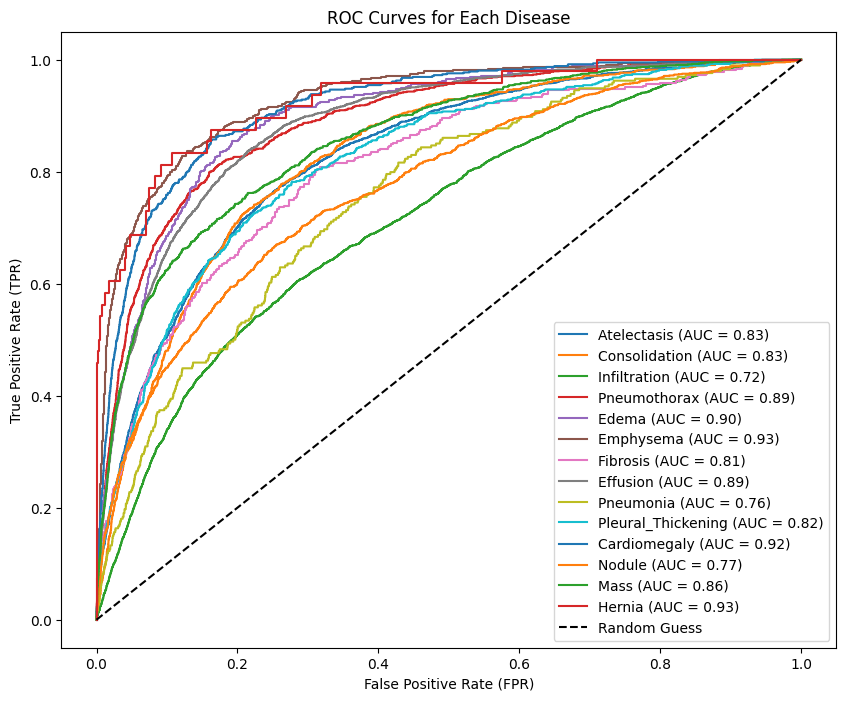

In [46]:
plt.figure(figsize=(10, 8))
for i, label in enumerate(disease_labels):
    fpr, tpr, _ = roc_curve(labels[:, i], predictions[:, i])
    plt.plot(fpr, tpr, label=f"{label} (AUC = {mean_auc_per_label[label]:.2f})")

plt.plot([0, 1], [0, 1], linestyle='--', color='black', label="Random Guess")
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curves for Each Disease')
plt.legend(loc='lower right')
plt.show()

**Plot Training and Validation Loss**

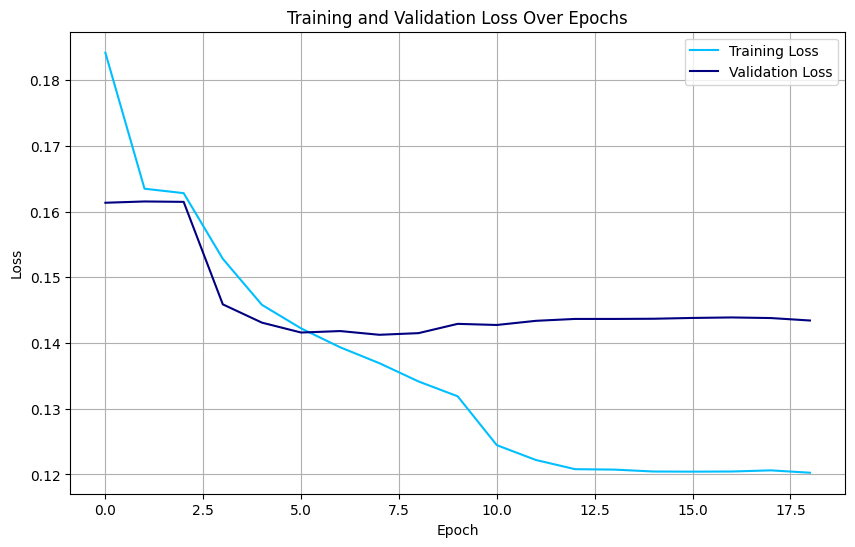

In [47]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses_1 + train_losses_2, label='Training Loss', color='deepskyblue')
plt.plot(val_losses_1 + val_losses_2, label='Validation Loss', color='navy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

**Plot Training and Validation Loss only Fine-tuning**

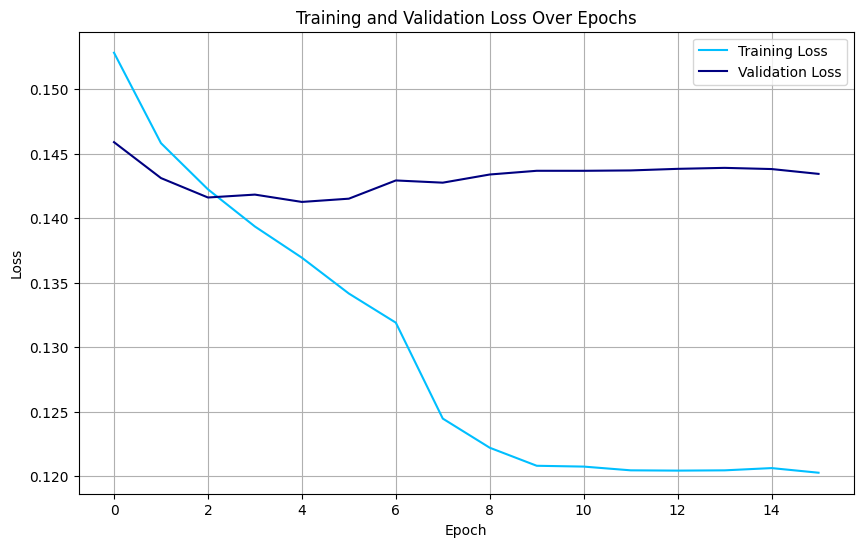

In [48]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses_2, label='Training Loss', color='deepskyblue')
plt.plot(val_losses_2, label='Validation Loss', color='navy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

**Plot Validation AUC**

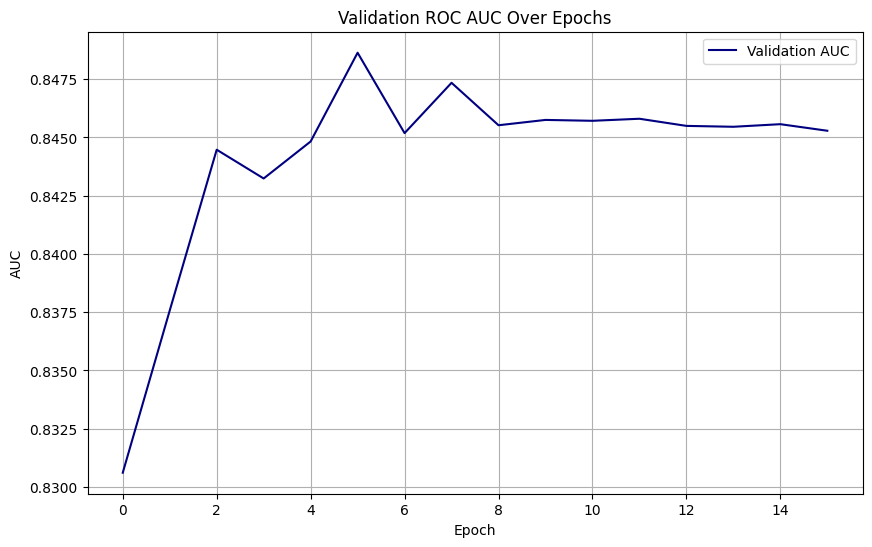

In [49]:
plt.figure(figsize=(10, 6))
plt.plot(val_aucs_2, label='Validation AUC', color='navy')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('Validation ROC AUC Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

**Plot Validation AUC only Fine-tuning**

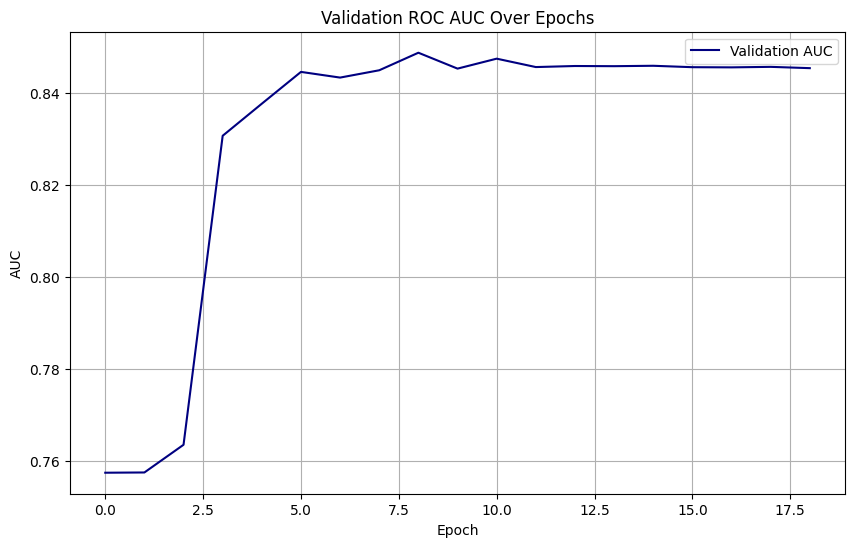

In [50]:
plt.figure(figsize=(10, 6))
plt.plot(val_aucs_1 + val_aucs_2, label='Validation AUC', color='navy')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('Validation ROC AUC Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

**Plot BYOL Loss**

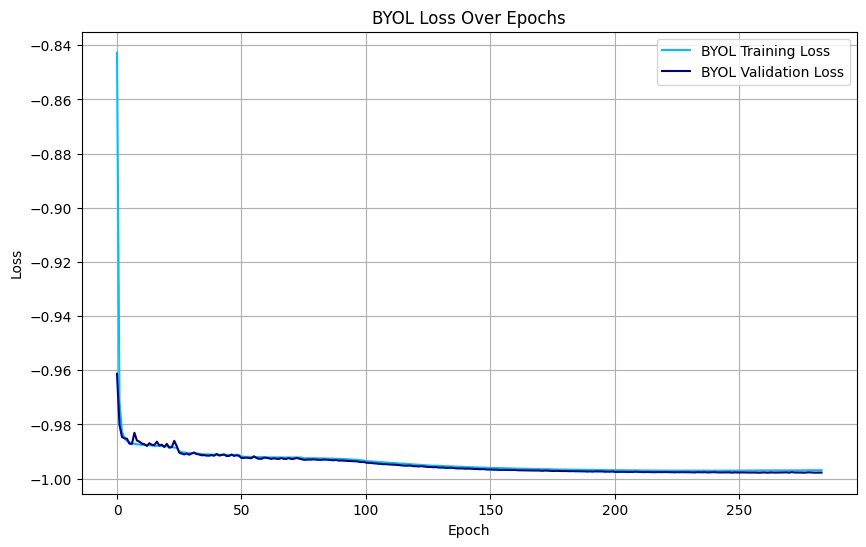

In [51]:
plt.figure(figsize=(10, 6))
plt.plot(byol_train_losses, label='BYOL Training Loss', color='deepskyblue')
plt.plot(byol_val_losses, label='BYOL Validation Loss', color='navy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('BYOL Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()